# Visualization of K-Means applied on features

In [12]:
import cv2 as cv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [13]:
import src
from src.data_generation.utils import downsample_img
from src.hierarchical_properties.clustering import k_means_on_feature
import importlib

importlib.reload(src.hierarchical_properties.clustering)
from src.hierarchical_properties.clustering import k_means_on_feature

In [14]:
# Constants
img_path = r"../../data/img_trial/dog_2.jpg"

full_size = 448
patch_sizes = [112, 56, 28, 14]
n_channels_patches = [64*4*2, 128*4*2, 256*4*2, 512*4*2]
patches_paths = ["../../data/np/dog/supervised/supervised_block1.npy",
                 "../../data/np/dog/supervised/supervised_block2.npy",
                 "../../data/np/dog/supervised/supervised_block3.npy",
                 "../../data/np/dog/supervised/supervised_block4.npy"]

# K-Means
k_s = [2, 4, 6, 8] #[2, 3, 4, 5, 6, 7, 8, 9, 10]
max_iter = 100
epsilon = 0.2
attempts = 10
normalize = True
bilinear_interpolation_flag = cv.INTER_LINEAR
nn_interpolation_flag = cv.INTER_NEAREST

weight_original_img = 0.4
weight_colored_patch = 0.4
gamma = 0

In [15]:
img = cv.imread(img_path)
img = downsample_img(img, full_size, full_size, False)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

In [16]:
for patch_path in patches_paths:
    patch = np.load(patch_path)
    print(patch.shape)

(112, 112, 512)
(56, 56, 1024)
(28, 28, 2048)
(14, 14, 4096)


In [17]:
final_images_bilinear_interp = []
final_images_nn_interp = []
# Sum of squared distance from each point to their corresponding centers.
# Each element corresponds to a different number of clusters.
compactness_k_dict = {}

j = 0
for patch_path in patches_paths:
    patch = np.load(patch_path) #cv.imread(patch_path)
    #patch = cv.cvtColor(patch, cv.COLOR_BGR2RGB)
    # Initialize dict that will contain compactness values for each k for
    # each patch
    compactness_k_dict[j] = []
    for k in k_s:
        seg_patch, compactness = k_means_on_feature(
            patch, n_clusters=k, max_iter=max_iter, epsilon=epsilon, attempts=attempts,
            normalize=normalize, n_channels=n_channels_patches[j], plot=False)
        compactness_k_dict[j].append(compactness)
        seg_full = downsample_img(
            seg_patch, full_size, full_size, False,
            interpolation_method=bilinear_interpolation_flag)

        # Convert the original image as grayscale image to put it in the
        # background to be able to put the patch (the output of Kmeans)
        # over it in a transparent way.
        # Single channel grayscale image
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # Repeat the grayscale image along all the 3 channels
        stacked_img = np.stack((img_gray,) * 3, axis=-1)
        final_img_bilinear_interp = cv.addWeighted(
            stacked_img, weight_original_img, seg_full, weight_colored_patch,
            gamma)
        final_images_bilinear_interp.append(final_img_bilinear_interp)

        seg_full_nearest_neighbor_interp = downsample_img(
            seg_patch, full_size, full_size, False,
            interpolation_method=nn_interpolation_flag)

        nearest_neighbor_interp_final_img = cv.addWeighted(
            stacked_img, weight_original_img,
            seg_full_nearest_neighbor_interp,
            weight_colored_patch, gamma)
        final_images_nn_interp.append(nearest_neighbor_interp_final_img)
    j += 1

C:\Users\lucam\miniconda3\envs\Project\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\lucam\miniconda3\envs\Project\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\lucam\miniconda3\envs\Project\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\lucam\miniconda3\envs\Project\lib\site-packages\sklearn\cluster\_kmeans.py:1334: User

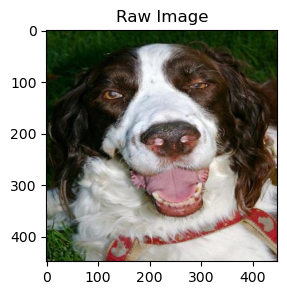

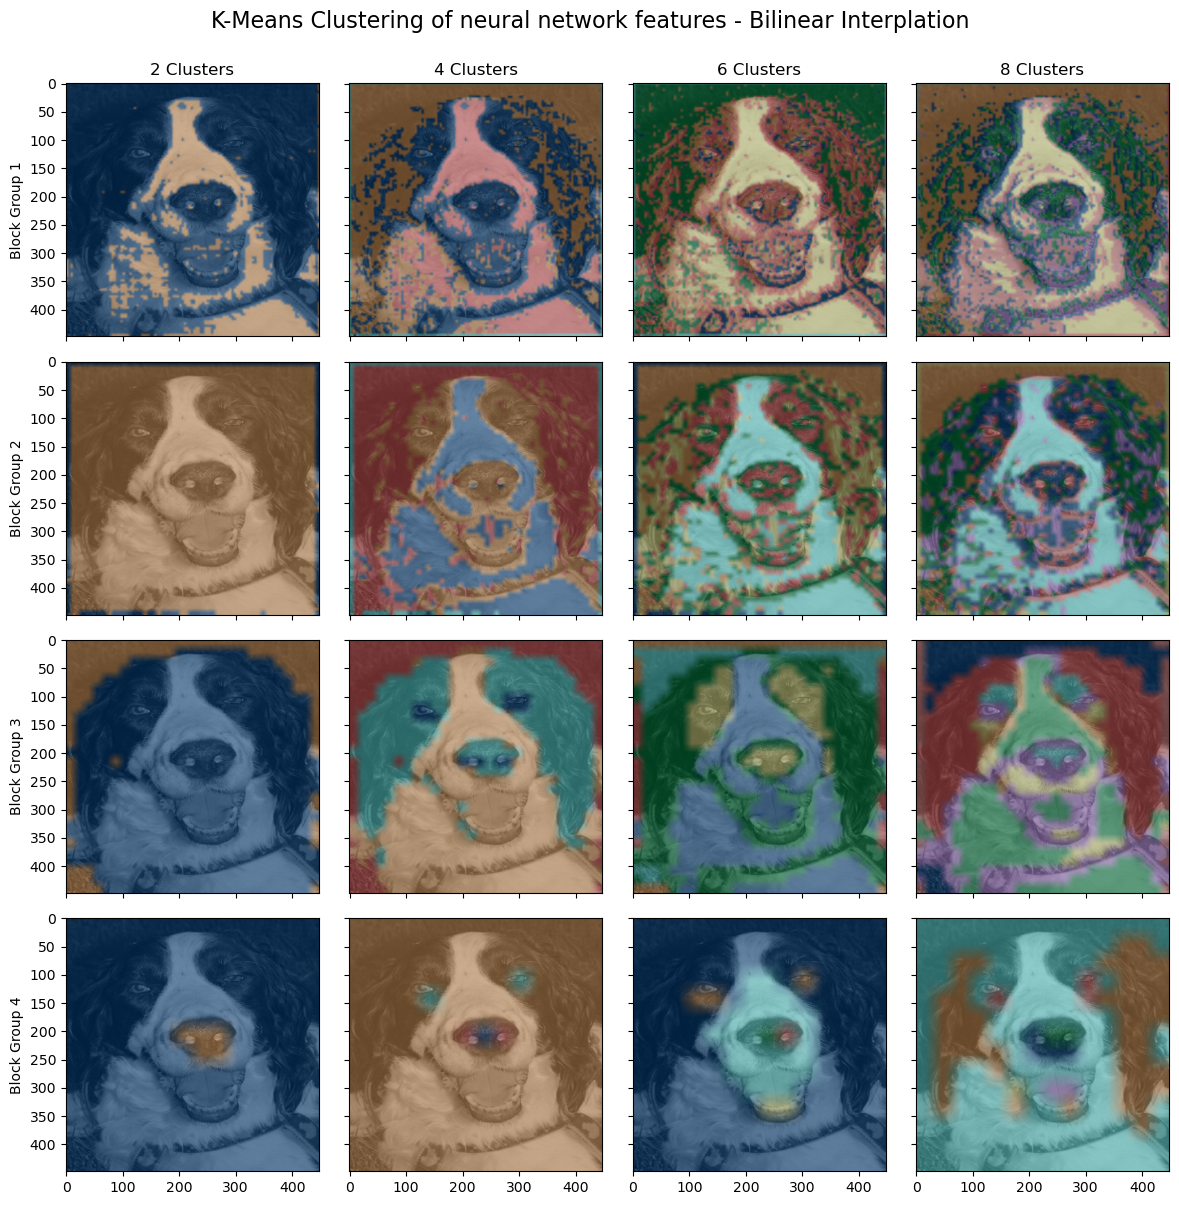

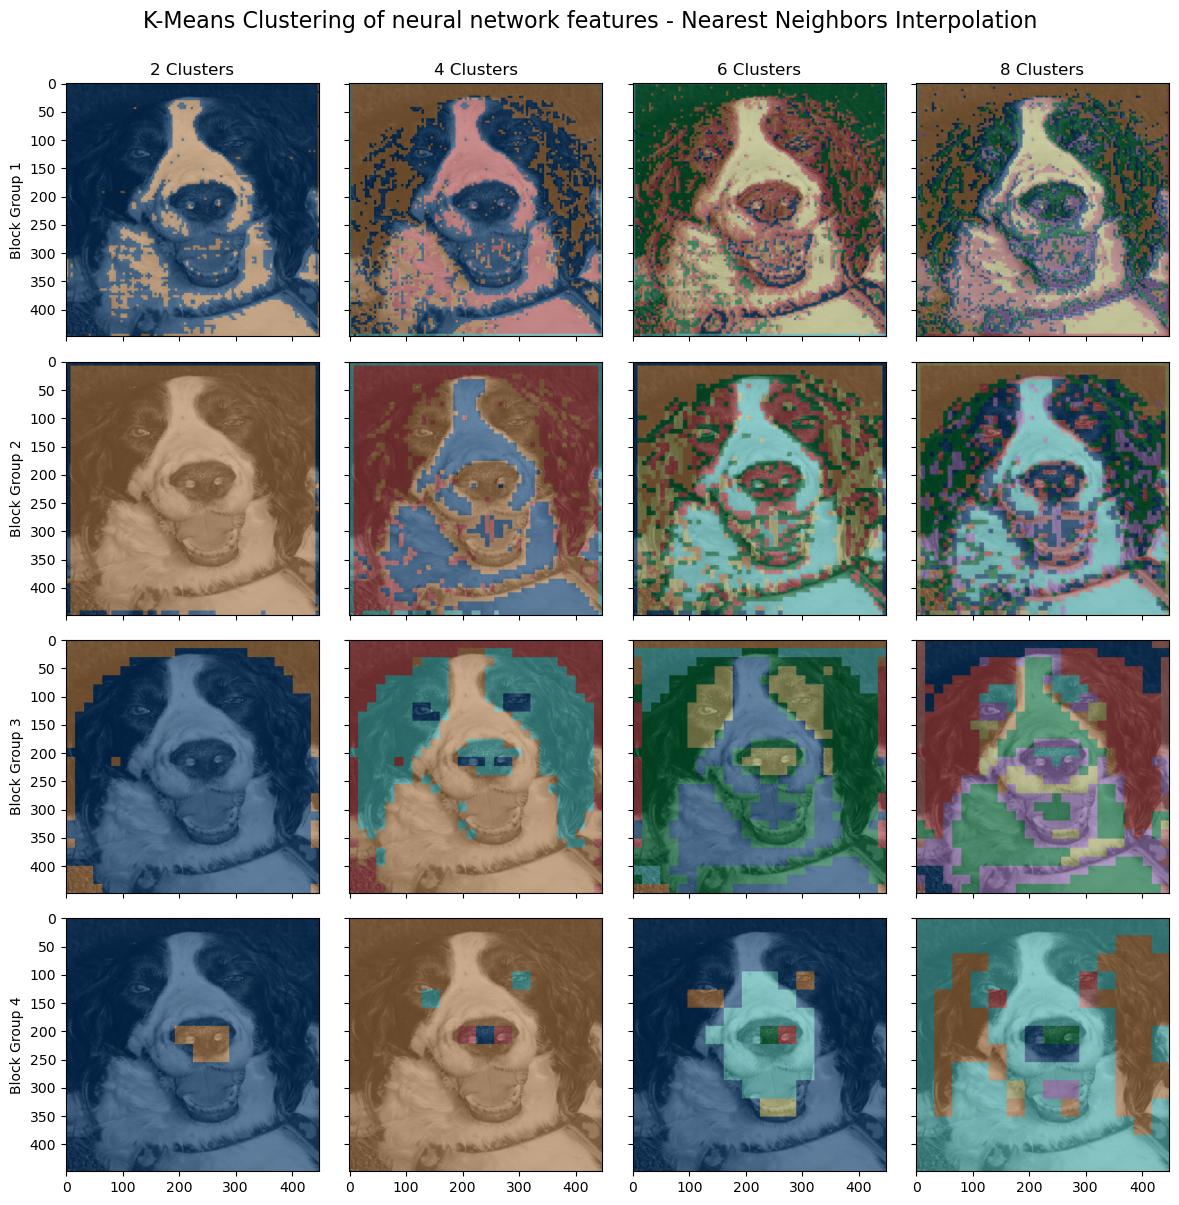

In [18]:
# Plots

# Raw Image
fig = plt.figure(figsize=(3, 3))
plt.title("Raw Image")
plt.imshow(img)
plt.show()

# Bilinear Interplation
fig, axs = plt.subplots(nrows=len(patch_sizes), ncols=len(k_s), figsize=(12, 12),
                        sharex=True, sharey=True)
axs = axs.flatten()
i = 0
for img_kmeans, ax in zip(final_images_bilinear_interp, axs):
    if i % len(k_s) == 0:
        ax.set_ylabel(f"Block Group {int((i / len(k_s)) + 1)}")
    if i < len(k_s):
        ax.title.set_text(f"{k_s[i]} Clusters")
    ax.imshow(img_kmeans)
    i += 1
fig.suptitle("K-Means Clustering of neural network features - Bilinear Interplation", y=1.0, fontsize=16)
fig.tight_layout()
plt.show()

# Nearest Neighbors Interpolation
fig, axs = plt.subplots(nrows=len(patch_sizes), ncols=len(k_s), figsize=(12, 12),
                        sharex=True, sharey=True)
axs = axs.flatten()
i = 0
for img_kmeans, ax in zip(final_images_nn_interp, axs):
    if i % len(k_s) == 0:
        ax.set_ylabel(f"Block Group {int((i / len(k_s)) + 1)}")
    if i < len(k_s):
        ax.title.set_text(f"{k_s[i]} Clusters")
    ax.imshow(img_kmeans)
    i += 1
fig.suptitle("K-Means Clustering of neural network features - Nearest Neighbors Interpolation", y=1.0, fontsize=16)
fig.tight_layout()
plt.show()

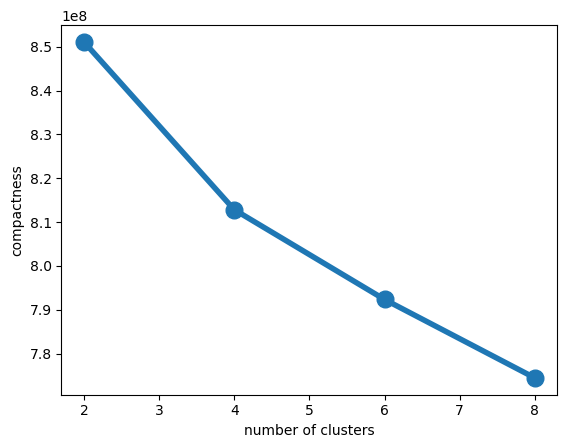

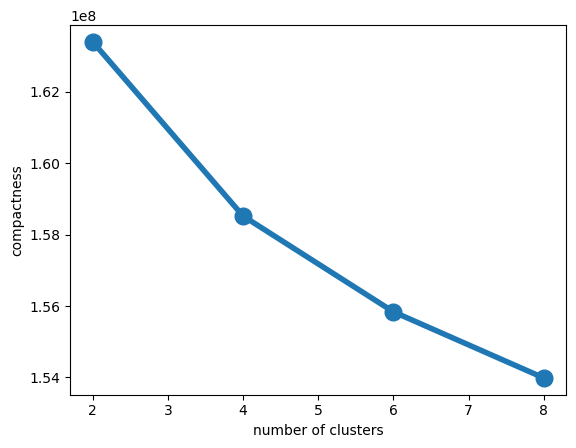

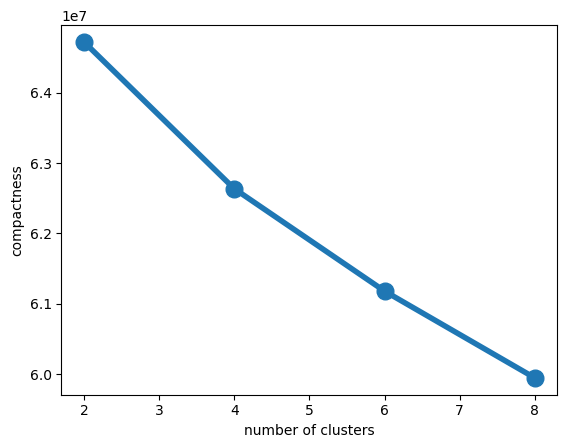

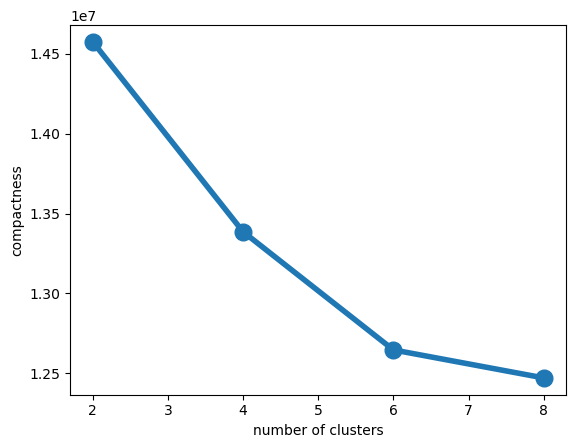

In [19]:
for idx in range(len(patches_paths)):
    plt.plot(k_s, compactness_k_dict[idx], 'o-', linewidth=4, markersize=12);
    plt.xlabel('number of clusters')
    plt.ylabel('compactness')
    plt.show()